In [1]:
import warnings

warnings.filterwarnings('ignore')

import os

from tools.modeling.timeserieshyperparamtuner import TimeSeriesHyperParamTuner
from tools.modeling.timeseriesmodeler import TimeSeriesModeler

from nba.common import add_game_log_lag, add_game_log_last_5
import nba.constants as c

from xgboost import XGBRegressor
from hyperopt import hp

import numpy as np
import pandas as pd

import shap


ROOT_DIR = os.getcwd()[:-17] # verify this points to the root directory of the project

season = c.SEASON_2022_2023

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [2]:
# Get all players game logs for the top 100 scorers of the season
# df = get_all_players_by_season(season)
# df = df.loc[df[c.GP] >= 30]
# df = df.sort_values(by=c.PTS, ascending=False)
# player_ids = df[c.PLAYER_ID].head(100).tolist()
# logs = get_players_game_log(player_ids, season)
# logs.to_csv(ROOT_DIR + '/data/game_logs/{season}/top_100_scorers_{season}_game_log.csv'.format(season=season), index=False)

In [3]:
logs = pd.read_csv(ROOT_DIR + '/data/game_logs/{season}/top_100_scorers_{season}_game_log.csv'.format(season=season))
logs

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON
0,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201198,2023-04-06,PHI vs. MIA,L,...,2,2,0,2,0,1,4,21,-11,2022-23
1,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201181,2023-04-04,PHI vs. BOS,W,...,6,3,0,2,1,3,9,52,17,2022-23
2,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201174,2023-04-02,PHI @ MIL,L,...,5,1,0,0,1,4,4,28,-10,2022-23
3,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201150,2023-03-31,PHI vs. TOR,W,...,1,5,0,1,0,3,6,25,0,2022-23
4,2022-23,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,22201139,2023-03-29,PHI vs. DAL,W,...,3,4,1,1,1,4,6,25,10,2022-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200072,2022-10-28,CLE @ BOS,W,...,2,0,0,0,0,2,2,12,25,2022-23
6577,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200056,2022-10-26,CLE vs. ORL,W,...,1,1,1,1,0,5,5,18,11,2022-23
6578,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200039,2022-10-23,CLE vs. WAS,W,...,3,0,0,2,1,2,4,15,-1,2022-23
6579,2022-23,1628386,Jarrett Allen,1610612739,CLE,Cleveland Cavaliers,22200032,2022-10-22,CLE @ CHI,W,...,2,2,0,1,0,2,3,8,5,2022-23


In [4]:
logs[c.GAME_DATE] = pd.to_datetime(logs[c.GAME_DATE])
logs = add_game_log_last_5(logs)
logs = add_game_log_lag(logs)

logs.sort_values(by=[c.GAME_DATE])
logs

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FG_PCT_LAG,FGM_LAG,FGA_LAG,FG3M_LAG,FG3A_LAG,FG3_PCT_LAG,FTM_LAG,FTA_LAG,FT_PCT_LAG,PLUS_MINUS_LAG
552,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200002,2022-10-18,LAL @ GSW,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200016,2022-10-20,LAL vs. LAC,L,...,0.462,12.0,26.0,3.0,10.0,0.300,4.0,4.0,1.000,-10.0
550,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200037,2022-10-23,LAL vs. POR,L,...,0.412,7.0,17.0,2.0,8.0,0.250,4.0,6.0,0.667,-1.0
549,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200064,2022-10-26,LAL @ DEN,L,...,0.545,12.0,22.0,2.0,9.0,0.222,5.0,7.0,0.714,2.0
548,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200076,2022-10-28,LAL @ MIN,L,...,0.381,8.0,21.0,2.0,8.0,0.250,1.0,2.0,0.500,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201149,2023-03-31,IND vs. OKC,W,...,0.524,11.0,21.0,1.0,5.0,0.200,6.0,9.0,0.667,-11.0
4799,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201173,2023-04-02,IND @ CLE,L,...,0.625,5.0,8.0,1.0,3.0,0.333,4.0,5.0,0.800,-9.0
4798,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201190,2023-04-05,IND vs. NYK,L,...,0.417,5.0,12.0,1.0,2.0,0.500,8.0,8.0,1.000,-7.0
4797,2022-23,1631097,Bennedict Mathurin,1610612754,IND,Indiana Pacers,22201203,2023-04-07,IND vs. DET,L,...,0.353,6.0,17.0,1.0,3.0,0.333,4.0,6.0,0.667,-31.0


In [5]:
# Preprocess Data
PTS_PREDICTION_MASK = [c.PTS] + c.GAME_LOG_LAG_MASK + c.GAME_LOG_LAST_5_MASK
logs = logs[PTS_PREDICTION_MASK]
logs.dropna()

cats = logs.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    logs[col] = logs[col].astype('category')

In [6]:
rmse = {
    'base_model': 0,
    'tuned_model': 0,
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000
}

In [7]:
ts_modeler = TimeSeriesModeler(XGBRegressor())
ts_modeler.ts_train(params, logs, c.PTS)
rmse['base_model'] = ts_modeler.ts_rmse()

[0]	validation_0-rmse:8.31293	validation_1-rmse:9.72097
[100]	validation_0-rmse:1.18091	validation_1-rmse:10.38397
[200]	validation_0-rmse:1.07289	validation_1-rmse:10.41246
[300]	validation_0-rmse:1.07195	validation_1-rmse:10.41364
[400]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[500]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[600]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[700]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[800]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[900]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
[999]	validation_0-rmse:1.07194	validation_1-rmse:10.41359
RSME: 10.413594232838074
[0]	validation_0-rmse:8.83154	validation_1-rmse:8.25188
[100]	validation_0-rmse:1.95482	validation_1-rmse:9.00672
[200]	validation_0-rmse:1.01942	validation_1-rmse:9.13021
[300]	validation_0-rmse:0.92998	validation_1-rmse:9.15257
[400]	validation_0-rmse:0.92335	validation_1-rmse:9.15833
[500]	validation_0-rmse:0.92289	validatio

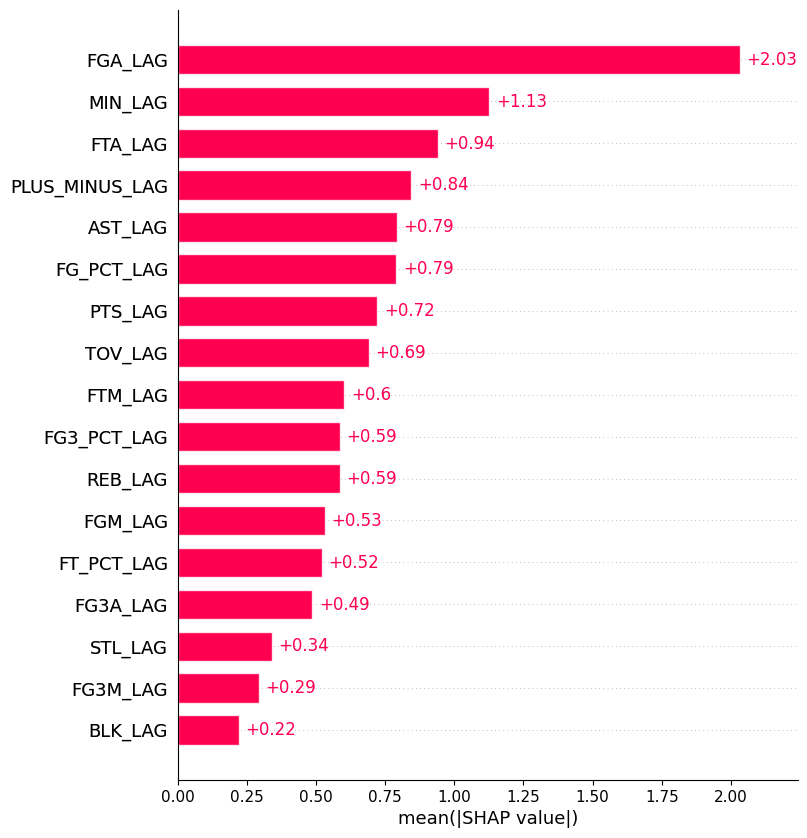

In [8]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)

In [9]:
space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
}

tuner = TimeSeriesHyperParamTuner(ts_modeler, space)
best = tuner.ts_optimize(250, logs, c.PTS)
best

[0]	validation_0-rmse:8.61559	validation_1-rmse:9.65439
[100]	validation_0-rmse:5.78529	validation_1-rmse:9.71719
[200]	validation_0-rmse:5.46047	validation_1-rmse:9.77375
[300]	validation_0-rmse:5.22422	validation_1-rmse:9.78263
[303]	validation_0-rmse:5.22422	validation_1-rmse:9.78263
RSME: 9.782627872768176                                
[0]	validation_0-rmse:9.02400	validation_1-rmse:8.21892
[100]	validation_0-rmse:5.57141	validation_1-rmse:8.65738
[200]	validation_0-rmse:5.13831	validation_1-rmse:8.75756
[300]	validation_0-rmse:4.93042	validation_1-rmse:8.83466
[303]	validation_0-rmse:4.93042	validation_1-rmse:8.83466
RSME: 8.834661043293474                                
[0]	validation_0-rmse:8.69307	validation_1-rmse:8.98160
[100]	validation_0-rmse:5.48508	validation_1-rmse:8.87474
[200]	validation_0-rmse:4.97281	validation_1-rmse:9.05410
[300]	validation_0-rmse:4.72863	validation_1-rmse:9.08826
[303]	validation_0-rmse:4.71931	validation_1-rmse:9.08939
RSME: 9.089388748298791 

{'colsample_bytree': 0.9284601599656607,
 'eta': 0.5,
 'eval_metric': 'rmse',
 'gamma': 4.36911085712762,
 'max_depth': 3.0,
 'min_child_weight': 9.0,
 'n_estimators': 456.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 129.0,
 'reg_lambda': 0.0023744102266332057,
 'subsample': 0.9}

In [10]:
ts_modeler.ts_train(best, logs, c.PTS)
rmse['tuned_model'] = ts_modeler.ts_rmse()
rmse

[0]	validation_0-rmse:8.59097	validation_1-rmse:9.54735
[100]	validation_0-rmse:7.22012	validation_1-rmse:9.40117
[200]	validation_0-rmse:7.00096	validation_1-rmse:9.45783
[300]	validation_0-rmse:6.86918	validation_1-rmse:9.48544
[400]	validation_0-rmse:6.80669	validation_1-rmse:9.48750
[455]	validation_0-rmse:6.74668	validation_1-rmse:9.49702
RSME: 9.497022055401558
[0]	validation_0-rmse:9.03001	validation_1-rmse:8.19964
[100]	validation_0-rmse:7.38596	validation_1-rmse:8.38868
[200]	validation_0-rmse:7.02230	validation_1-rmse:8.50938
[300]	validation_0-rmse:6.79821	validation_1-rmse:8.58294
[400]	validation_0-rmse:6.68424	validation_1-rmse:8.65464
[455]	validation_0-rmse:6.63967	validation_1-rmse:8.65361
RSME: 8.65361440012557
[0]	validation_0-rmse:8.71534	validation_1-rmse:8.97843
[100]	validation_0-rmse:7.40554	validation_1-rmse:8.63846
[200]	validation_0-rmse:7.04510	validation_1-rmse:8.71865
[300]	validation_0-rmse:6.81518	validation_1-rmse:8.77707
[400]	validation_0-rmse:6.63942

{'base_model': 9.464553163737294, 'tuned_model': 8.853611387193762}

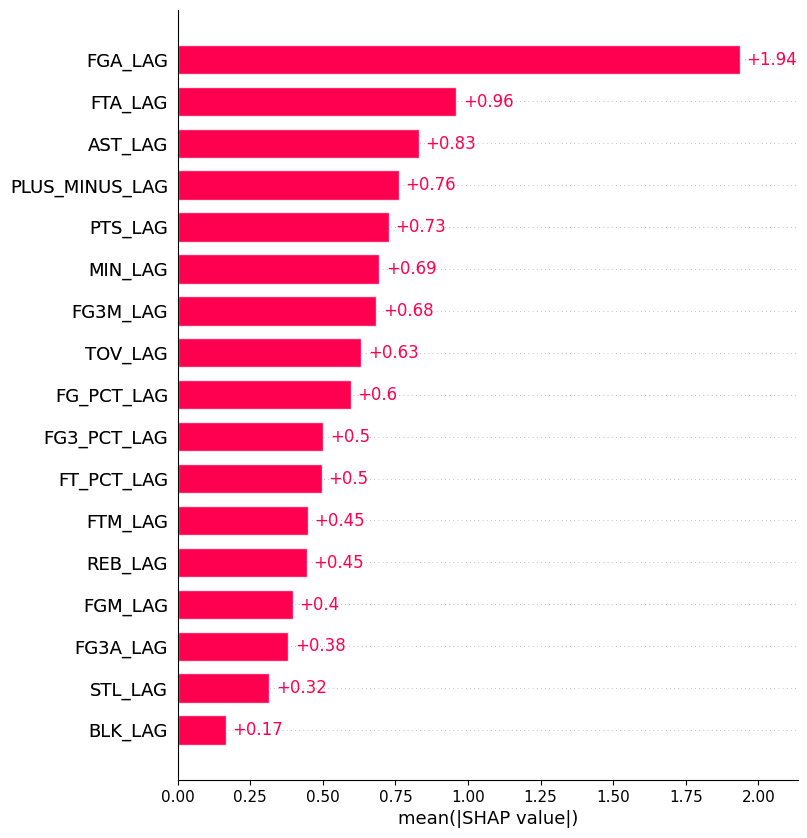

In [11]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)